In [ ]:
# importing libraries
import os
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet101,VGG19
from tensorflow.keras.layers import Dense,Dropout,Input,Flatten,BatchNormalization ,Activation,Conv2D,MaxPooling2D
import tensorflow as tf
from tqdm import tqdm
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#### Downloading data from kaggle to local environment

In [ ]:
os.environ['KAGGLE_USERNAME'] = "xxxx" 
os.environ['KAGGLE_KEY'] = "xxxx" 

In [ ]:
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 77% 49.0M/63.2M [00:03<00:01, 11.7MB/s]
100% 63.2M/63.2M [00:03<00:00, 20.6MB/s]


In [ ]:
!unzip 'age-gender-and-ethnicity-face-data-csv.zip'

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [ ]:
df = pd.read_csv('age_gender.csv')

In [ ]:
df.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

# Gender model

In [ ]:
gender_df = df[['gender','pixels']]
gender_df['gender'].unique()

array([0, 1])

In [ ]:
def pixels_2_image(string):
  arr = string.split()
  arr = np.array(arr,dtype='float')
  arr = np.reshape(arr,(48,48,1))
  return arr

gender_df['pixels'] = gender_df['pixels'].apply(pixels_2_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(48, 48, 1)


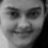

In [ ]:
image = gender_df['pixels'][2586]
print(image.shape)
cv2_imshow(image)

In [ ]:
# Splitting the data
X_train,X_test,y_train,y_test = train_test_split(gender_df['pixels'],gender_df['gender'],test_size=0.2,stratify=gender_df['gender'],random_state=40)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(18964,) (4741,) (18964,) (4741,)


In [ ]:
# count classes in train and test dataset
def count_unique(data):
  un,cn = np.unique(data,return_counts=True)
  for i in range(len(un)):
    print(un[i],cn[i])

print('In train')
count_unique(y_train)
print('In test')
count_unique(y_test)

In train
0 9913
1 9051
In test
0 2478
1 2263


### Dataset is almost balanced

In [ ]:
# Normalizing
X_train /= 255
X_test /= 255

In [ ]:
X_train = np.array([i for i in X_train])
X_test = np.array([i for i in X_test])

In [ ]:
# defining some useful callbacks
class Overfit(tf.keras.callbacks.Callback):
  def __init__(self,patience):
    self.patience=patience
    self.tracker = []
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy')-logs.get('val_accuracy')>0.01:
      self.tracker.append(-1)
    else:
      self.tracker.append(1)
    if epoch>=self.patience:
      if self.tracker[-self.patience:]==[-1]*self.patience:
        print("\nOverfitting begins....terminating the training")
        self.model.stop_training=True

lr_reduer = ReduceLROnPlateau(monitor = 'val_loss',patience = 4,verbose = 1,factor = 0.3, min_lr = 1e-6)

callbacks = [lr_reduer,Overfit(4)]

In [ ]:
# model building
def model_builder(activation,dr_rate):
  tf.keras.backend.clear_session()
  np.random.seed(0)

  input = Input(shape=(48,48,1))

  x = Conv2D(32,3,activation='relu')(input)
  x = Conv2D(64,3)(x)
  x = MaxPooling2D()(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)


  x = Conv2D(128,3,activation='relu')(x)
  x = Conv2D(256,3)(x)
  x = MaxPooling2D()(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(512,3,activation='relu',strides=(2,2))(x)
  x = Conv2D(1024,3)(x)
  x = MaxPooling2D()(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  x = Dense(128,kernel_initializer='he_normal')(x)
  x = Dropout(dr_rate)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Dense(1,activation=activation,kernel_initializer='he_normal')(x)

  model = Model(inputs=[input],outputs=[x])
  return model

model_gender = model_builder('sigmoid',0.8)
model_gender.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856 

In [ ]:
batch_size=32
epochs = 10
optimizer = tf.keras.optimizers.Adam()
model_gender.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = model_gender.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          steps_per_epoch=len(y_train)//batch_size,
          epochs=epochs,
          callbacks=callbacks)

Epoch 1/10
592/592 [==============================] - 30s 49ms/step - loss: 0.4204 - accuracy: 0.8009 - val_loss: 0.5946 - val_accuracy: 0.6102
Epoch 2/10
592/592 [==============================] - 28s 48ms/step - loss: 0.3022 - accuracy: 0.8684 - val_loss: 0.2721 - val_accuracy: 0.8844
Epoch 3/10
592/592 [==============================] - 28s 48ms/step - loss: 0.2725 - accuracy: 0.8834 - val_loss: 0.3155 - val_accuracy: 0.8753
Epoch 4/10
592/592 [==============================] - 28s 48ms/step - loss: 0.2410 - accuracy: 0.8982 - val_loss: 0.3023 - val_accuracy: 0.8895
Epoch 5/10
592/592 [==============================] - 28s 48ms/step - loss: 0.2305 - accuracy: 0.9039 - val_loss: 0.2551 - val_accuracy: 0.8937
Epoch 6/10
592/592 [==============================] - 28s 48ms/step - loss: 0.2058 - accuracy: 0.9164 - val_loss: 0.3399 - val_accuracy: 0.8758
Epoch 7/10
592/592 [==============================] - 28s 48ms/step - loss: 0.1944 - accuracy: 0.9213 - val_loss: 0.2444 - val_accuracy:

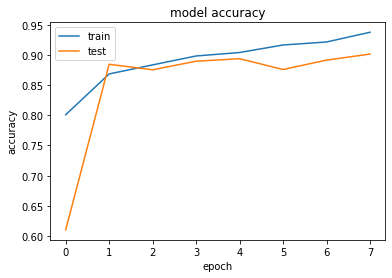

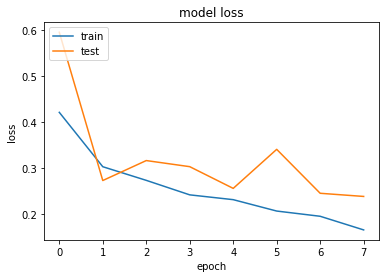

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def gender_predict(image_48481):
  cv2_imshow(image_48481*255)
  pred = model_gender.predict(np.array([image_48481]))[0]
  if pred<0.5:
    print('Male')
  else:
    print('Female')

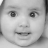

Male


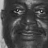

Male


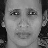

Male


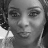

Female


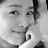

Female


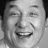

Male


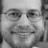

Male


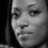

Female


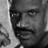

Male


In [ ]:
arr = [10,100,200,300,500,1000,2000,2500,3500]
for i in arr:
  gender_predict(X_test[i])

# Age model

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


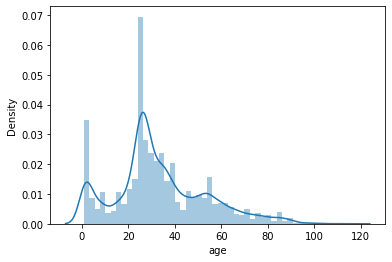

In [ ]:
age_df = df[['age','pixels']]
sns.distplot(age_df['age'],kde=True)

In [ ]:
age_df['pixels'] = age_df['pixels'].apply(pixels_2_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Splitting the data
X_train,X_test,y_train,y_test = train_test_split(age_df['pixels'],age_df['age'],test_size=0.2,stratify=gender_df['gender'],random_state=40)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(18964,) (4741,) (18964,) (4741,)


In [ ]:
# Normalizing
X_train /= 255
X_test /= 255
X_train = np.array([i for i in X_train])
X_test = np.array([i for i in X_test])

In [ ]:
# defining some useful callbacks
class Overfit_for_regression(tf.keras.callbacks.Callback):
  def __init__(self,patience):
    self.patience=patience
    self.tracker = []
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('mean_absolute_error')-logs.get('val_mean_absolute_error')<-1:
      self.tracker.append(-1)
    else:
      self.tracker.append(1)
    if epoch>=self.patience:
      if self.tracker[-self.patience:]==[-1]*self.patience:
        print("\nOverfitting begins....terminating the training")
        self.model.stop_training=True

In [ ]:
# model building
def model_builder_reg(activation,dr_rate):
  tf.keras.backend.clear_session()
  np.random.seed(0)

  input = Input(shape=(48,48,1))

  x = Conv2D(32,3,activation='relu')(input)
  x = Conv2D(64,3)(x)
  x = MaxPooling2D()(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  
  x = Conv2D(128,3,activation='relu')(x)
  x = Conv2D(256,3)(x)
  x = MaxPooling2D()(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(512,3,activation='relu',strides=(2,2))(x)
  x = Conv2D(1024,3)(x)
  x = MaxPooling2D()(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Flatten()(x)

  x = Dense(128,kernel_initializer='he_normal')(x)
  x = Dropout(dr_rate)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Dense(1,activation=activation,kernel_initializer='he_normal')(x)

  model = Model(inputs=[input],outputs=[x])
  return model

model_age = model_builder_reg('linear',0.2)
model_age.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856 

In [ ]:
batch_size=16
epochs = 20
optimizer = tf.keras.optimizers.Adam(0.0003)
model_age.compile(loss='mse',optimizer=optimizer,metrics=[tf.keras.metrics.mean_absolute_error])
callbacks = [lr_reduer,Overfit_for_regression(3)]
history = model_age.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          steps_per_epoch=len(y_train)//batch_size,
          epochs=epochs,
          callbacks=callbacks)

Epoch 1/20
1185/1185 [==============================] - 42s 34ms/step - loss: 621.7462 - mean_absolute_error: 20.0216 - val_loss: 232.0508 - val_mean_absolute_error: 11.9589
Epoch 2/20
1185/1185 [==============================] - 40s 34ms/step - loss: 121.0172 - mean_absolute_error: 8.2280 - val_loss: 130.5042 - val_mean_absolute_error: 8.6198
Epoch 3/20
1185/1185 [==============================] - 40s 34ms/step - loss: 96.0618 - mean_absolute_error: 7.3655 - val_loss: 87.9449 - val_mean_absolute_error: 6.9558
Epoch 4/20
1185/1185 [==============================] - 40s 34ms/step - loss: 81.0194 - mean_absolute_error: 6.8257 - val_loss: 92.5623 - val_mean_absolute_error: 7.3290
Epoch 5/20
1185/1185 [==============================] - 40s 34ms/step - loss: 71.5584 - mean_absolute_error: 6.4143 - val_loss: 104.6969 - val_mean_absolute_error: 7.7253
Epoch 6/20
1185/1185 [==============================] - 40s 33ms/step - loss: 61.3391 - mean_absolute_error: 5.9956 - val_loss: 133.1557 - val_

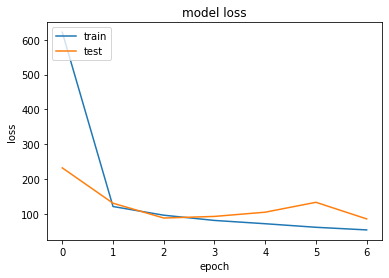

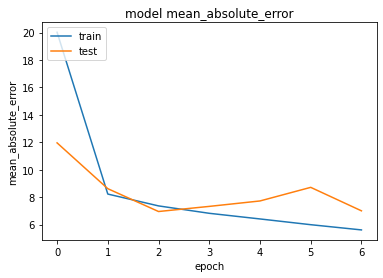

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def age_predict(image_48481):
  cv2_imshow(image_48481*255)
  pred = model_age.predict(np.array([image_48481]))[0][0]
  print(int(abs(pred)))

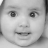

4


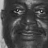

57


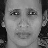

35


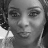

25


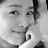

32


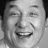

54


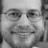

44


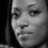

29


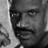

37


In [ ]:
arr = [10,100,200,300,500,1000,2000,2500,3500]
for i in arr:
  age_predict(X_test[i])

In [ ]:
os.chdir('drive/MyDrive')
model_gender.save('best_model_gender.h5')
print('Saved model to disk')
model_age.save('best_model_age.h5')
print('Saved model to disk')

Saved model to disk
Saved model to disk
